In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
data_path = Path('../data/')
df        = pd.read_csv(data_path / 'interim' / 'fed_emp.csv')

In [3]:
# Removing the lines for which the target in unknown
df                                   = df[~df.EDLVL.isnull()]
# Removing the nan values in columns by either adding a new category
# or dropping the lines
df.loc[df.GSEGRD.isnull(), 'GSEGRD'] = 0
df.loc[df.OCC.isnull(), 'OCC']       = 0
df                                   = df[~df.SUPERVIS.isnull()]
df                                   = df[~df.TOA.isnull()]
df                                   = df[~df.SALARY.isnull()]
df                                   = df[~df.LOS.isnull()]
df.isnull().sum(axis = 0)

AGYSUB      0
LOC         0
AGELVL      0
EDLVL       0
GSEGRD      0
LOSLVL      0
OCC         0
PATCO       0
PPGRD       0
SALLVL      0
STEMOCC     0
SUPERVIS    0
TOA         0
WORKSCH     0
WORKSTAT    0
SALARY      0
LOS         0
dtype: int64

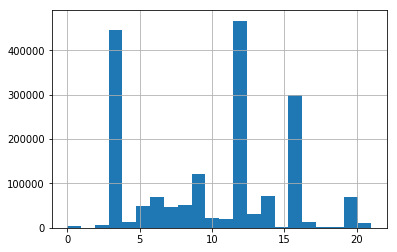

In [4]:
df_data    = df.drop(['EDLVL'], axis = 1)
df_target  = df['EDLVL']
df_target  = df_target - 1 # Values between 0 and 21 instead of 1 and 22
df_target.hist(bins = 22)

In [5]:
numerical_columns = ['SALARY', 'LOS']
df_num            = df_data[numerical_columns]
df_cat            = df_data.drop(numerical_columns, axis = 1) 

In [6]:
columns_encoders = {
    col : {
        val : i 
        for i, val in enumerate(df[col].unique())
    }
    for col in df_cat.columns
}

In [7]:
for col in df_cat.columns:
    df_cat[col] = df_cat[col].apply(lambda x: columns_encoders[col][x])

In [10]:
df_cat.shape, df_num.shape

((1812893, 14), (1812893, 2))

In [73]:
class CategoricalEmbeddings(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim):
        super(CategoricalEmbeddings, self).__init__()
        self.col_order = col_order 
        self.cat_embs  = nn.ModuleDict({
            col: nn.Embedding(len(col_encoders[col]), col_to_emb_dim[col])
            for col in col_order
        })
        
    def forward(self, cat_variables):
        embeddings = [self.cat_embs[col](cat_variables[col]) for col in self.col_order]
        
        return torch.cat(embeddings, dim = 1)

In [94]:
class EdlvlClassifier(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim):
        super(EdlvlClassifier, self).__init__()
        self.cat_emb    = CategoricalEmbeddings(col_order, col_encoders, col_to_emb_dim)
        sum_cat_emb_dim = sum(col_to_emb_dim.values())
        self.linear1    = nn.Linear(sum_cat_emb_dim + 2, 128)
        self.linear2    = nn.Linear(128, 22)
        
    def forward(self, cat_variables, num_variables):
        cat_embeddings = self.cat_emb(cat_variables)
        cat_num_tensor = torch.cat([cat_embeddings, num_variables], dim = 1)
        out_linear1    = F.relu(self.linear1(cat_num_tensor))
        out_linear2    = self.linear2(out_linear1)
        
        return out_linear2

In [95]:
model = EdlvlClassifier(
    list(columns_encoders.keys()),
    columns_encoders,
    {
        col : 2
        for col in columns_encoders
    }
)
model

EdlvlClassifier(
  (cat_emb): CategoricalEmbeddings(
    (cat_embs): ModuleDict(
      (AGELVL): Embedding(12, 2)
      (AGYSUB): Embedding(523, 2)
      (GSEGRD): Embedding(16, 2)
      (LOC): Embedding(219, 2)
      (LOSLVL): Embedding(10, 2)
      (OCC): Embedding(656, 2)
      (PATCO): Embedding(7, 2)
      (PPGRD): Embedding(933, 2)
      (SALLVL): Embedding(25, 2)
      (STEMOCC): Embedding(100, 2)
      (SUPERVIS): Embedding(6, 2)
      (TOA): Embedding(18, 2)
      (WORKSCH): Embedding(10, 2)
      (WORKSTAT): Embedding(2, 2)
    )
  )
  (linear1): Linear(in_features=30, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=22, bias=True)
)

In [83]:
df_batch = df_cat.head(16)
df_batch

,AGYSUB,LOC,AGELVL,GSEGRD,LOSLVL,OCC,PATCO,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,1,1,1,1,0,1,0,0
3,0,0,1,2,1,1,1,2,2,1,0,1,0,0
4,0,0,2,1,1,1,1,1,1,1,0,1,0,0
6,0,0,1,3,2,2,0,3,3,1,0,2,0,0
8,0,0,1,4,1,1,1,4,4,1,0,1,0,0
9,0,0,3,3,1,3,0,3,3,1,0,2,0,0
10,0,0,4,3,3,1,1,3,3,1,0,2,0,0
11,1,1,5,4,4,4,1,4,4,2,0,0,0,0
12,1,1,6,4,2,5,0,4,4,1,1,3,0,1


In [76]:
cat_variables = {
    col : torch.tensor(list(df_batch[col]))
    for col in df_batch.columns
}
cat_variables['GSEGRD']

tensor([0, 1, 2, 1, 3, 4, 3, 3, 4, 4, 4, 2, 5, 4, 6, 4])

In [97]:
res = model(cat_variables, torch.randn(16, 2))

In [99]:
res

tensor([[ 0.0662, -0.2724,  0.3547, -0.1773, -0.2663, -0.0088, -0.3641, -0.2393,
          0.0982,  0.0331,  0.4205,  0.3597, -0.1974, -0.1678, -0.1116,  0.4877,
         -0.1344, -0.0835,  0.1863, -0.1037, -0.0093,  0.4131],
        [ 0.0316, -0.1237,  0.2853, -0.2274, -0.5413,  0.2737, -0.3677, -0.1763,
          0.1286, -0.2150,  0.2207,  0.2178, -0.2227, -0.0266, -0.1185,  0.3335,
         -0.2782,  0.3566,  0.2557, -0.0411,  0.0132,  0.1173],
        [ 0.1887,  0.0067,  0.3960, -0.4267, -0.5251,  0.1694, -0.8272, -0.2433,
         -0.0542,  0.1473,  0.3441,  0.3015, -0.5614, -0.0730, -0.0041,  0.5225,
         -0.4058,  0.4464, -0.0782,  0.1024,  0.1975,  0.1498],
        [ 0.1077, -0.1782,  0.2481, -0.2364, -0.5326,  0.2045, -0.4111, -0.1821,
          0.0715, -0.1889,  0.1701,  0.1973, -0.2604,  0.0066, -0.1104,  0.2470,
         -0.2132,  0.3306,  0.2508, -0.0088,  0.0263,  0.1688],
        [ 0.0486, -0.1877,  0.4318, -0.1710, -0.0468,  0.4768,  0.1193, -0.0011,
          0.269

In [63]:
[t.shape for t in res]

[torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10]),
 torch.Size([16, 10])]

In [64]:
t1 = res[0]

In [65]:
t2 = res[1]

In [72]:
torch.cat([t1, t2], dim = 1).shape

torch.Size([16, 20])